<a href="https://colab.research.google.com/github/arionpap4/llm_ast/blob/main/AST_LLM_APap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install trl
!pip install peft
!pip install bitsandbytes


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

actual_model = "keeeeenw/MicroLlama"
tokenizer = AutoTokenizer.from_pretrained(actual_model, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(actual_model, trust_remote_code=True) #.cuda() no gpu use


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import pipeline

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Set up the pipeline to use GPU (if available)
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device=device)
# Test the model with arithmetic expressions
equations = [
    "3 * 5 + 2 =",
    "(4 + 6) * 2 =",
    "10 / 2 + 8 =",
    "7 * (3 + 2) ="
]

# Generate outputs for each equation
for equation in equations:
    output = text_generator(equation, max_length=20, do_sample=True, temperature=0.7)
    print(f"Prompt: {equation}")
    print(f"Model's Output: {output[0]['generated_text']}")
    print("-" * 50)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: 3 * 5 + 2 =
Model's Output: 3 * 5 + 2 = 100.

A: 
--------------------------------------------------
Prompt: (4 + 6) * 2 =
Model's Output: (4 + 6) * 2 = 8.
  # [12
--------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Prompt: 10 / 2 + 8 =
Model's Output: 10 / 2 + 8 = 10 / 2 + 8
--------------------------------------------------
Prompt: 7 * (3 + 2) =
Model's Output: 7 * (3 + 2) = 10.
We can see the
--------------------------------------------------


In [ ]:
import random

# Function to generate a random arithmetic expression with optional brackets
def generate_equation_with_brackets():
    # Choose random numbers and operators
    num1 = random.randint(1, 10)
    num2 = random.randint(1, 10)
    num3 = random.randint(1, 10)
    operators = ['+', '-', '*', '/']

    # Randomly pick operators
    op1 = random.choice(operators)
    op2 = random.choice(operators)

    # Randomly decide where to place brackets (if at all)
    bracket_positions = random.choice([
        f"({num1} {op1} {num2}) {op2} {num3}",  # Brackets around the first part
        f"{num1} {op1} ({num2} {op2} {num3})",  # Brackets around the second part
        f"({num1} {op1} {num2} {op2} {num3})",  # Brackets around the entire expression
        f"{num1} {op1} {num2} {op2} {num3}"     # No brackets
    ])

    # Evaluate the result using eval
    try:
        result = eval(bracket_positions)
    except ZeroDivisionError:
        result = None

    # Return the expression and its result
    return bracket_positions, result

# Generate a few samples
for _ in range(10):
    expr, res = generate_equation_with_brackets()
    if res is not None:  # Skip expressions with division by zero
        print(f"{expr} = {res}")


(9 - 10 + 1) = 0
4 / (8 + 8) = 0.25
3 * (9 + 2) = 33
1 + 3 - 7 = -3
(10 * 3 / 8) = 3.75
(6 * 9 - 8) = 46
(1 - 9 * 6) = -53
(6 / 4 * 9) = 13.5
(5 + 1 + 2) = 8
6 - 2 * 2 = 2


In [ ]:
import json

# Generate a list of arithmetic equations with brackets for training
training_data_with_brackets = []
for _ in range(10000):  # Generate 1000 samples
    expr, res = generate_equation_with_brackets()
    if res is not None:
        training_data_with_brackets.append({"prompt": expr, "response": f"= {res}"})

# Save the data to a JSON file
with open("arithmetic_training_data_with_brackets.json", "w") as f:
    json.dump(training_data_with_brackets, f)

# Download the file to your local system
from google.colab import files
files.download("arithmetic_training_data_with_brackets.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset, Dataset


# Set the pad_token to eos_token if no explicit pad_token is available
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    # Tokenize the input (prompt) and output (response) sequences
    tokenized_inputs = tokenizer(examples['prompt'], padding='max_length', truncation=True, max_length=512)
    tokenized_responses = tokenizer(examples['response'], padding='max_length', truncation=True, max_length=512)

    # Create labels that match the input length
    # Labels for the prompt part are set to -100, and the response part will have the tokenized response
    labels = [-100] * len(tokenized_inputs['input_ids'])  # Mask out the input (prompt)
    labels[len(tokenized_inputs['input_ids']) - len(tokenized_responses['input_ids']):] = tokenized_responses['input_ids']

    return {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'labels': labels  # Ensure labels match input length
    }


# Load your custom dataset (assuming the data is in JSON format)
dataset_folder = "/content/arithmetic_training_data_with_brackets.json"  # Path to your JSON file
dataset = load_dataset('json', data_files=dataset_folder, split="train")
print(dataset)

tokenized_dataset = dataset.map(tokenize_function, batched=True)  # This should return a Dataset object


Generating train split: 0 examples [00:00, ? examples/s]

Dataset({
    features: ['prompt', 'response'],
    num_rows: 9989
})


Map:   0%|          | 0/9989 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorForLanguageModeling

# Define a data collator for language modeling, which dynamically pads to the longest sequence in a batch
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,  # Set to False because you're training a causal language model (not masked language modeling)
)


In [ ]:
# Split the dataset into training and evaluation sets
split_datasets = tokenized_dataset.train_test_split(test_size=0.2)

# Separate train and eval datasets
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']


In [ ]:
print(len(eval_dataset))

1998


In [ ]:
from transformers import get_linear_schedule_with_warmup, EarlyStoppingCallback

# Define training arguments with improvements
training_args = TrainingArguments(
    output_dir="./results",                 # Output directory
    evaluation_strategy="epoch",            # Evaluate after each epoch
    logging_strategy="steps",               # Log training loss after a few steps
    logging_steps=50,                       # Log every 50 steps
    learning_rate=5e-5,                     # Initial learning rate
    num_train_epochs=10,                    # Increase number of epochs
    per_device_train_batch_size=4,          # Decrease batch size to avoid memory issues
    per_device_eval_batch_size=4,           # Decrease evaluation batch size
    gradient_accumulation_steps=2,          # Accumulate gradients over 2 steps to simulate larger batch size
    weight_decay=0.01,                      # Weight decay to prevent overfitting
    warmup_steps=500,                       # Warmup steps to gradually increase LR
    lr_scheduler_type="linear",             # Linear scheduler with warmup
    save_strategy="epoch",                  # Save checkpoint every epoch
    save_total_limit=3,                     # Only save the 3 most recent checkpoints
    fp16=True,                              # Enable mixed precision training
    logging_dir="./logs",                   # Directory for storing logs
    load_best_model_at_end=True,            # Load the best model at the end of training
    metric_for_best_model="eval_loss",      # Use evaluation loss as the metric for best model
)

# Implement early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,      # Your training dataset
    eval_dataset=eval_dataset,        # Your validation dataset
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Early stopping
)

# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.382600,0.377413


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


Epoch,Training Loss,Validation Loss
1,0.382600,0.377413


KeyboardInterrupt: 

In [ ]:
from transformers import Trainer, TrainingArguments, get_linear_schedule_with_warmup, EarlyStoppingCallback


# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",          # Output directory
    evaluation_strategy="epoch",     # Evaluate the model after each epoch
    logging_strategy="steps",        # Log training loss after every few steps
    logging_steps=50,                # Log every 50 steps
    learning_rate=5e-5,              # Learning rate for optimization
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    num_train_epochs=5,              # Number of training epochs
    weight_decay=0.01,               # Weight decay to prevent overfitting
    logging_dir="./logs",            # Directory for storing logs
    fp16=True,  # Enable mixed precision training
)

# Implement early stopping
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,      # Your training dataset
    eval_dataset=eval_dataset,        # Your validation dataset
   # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Early stopping
)


# Train the model
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

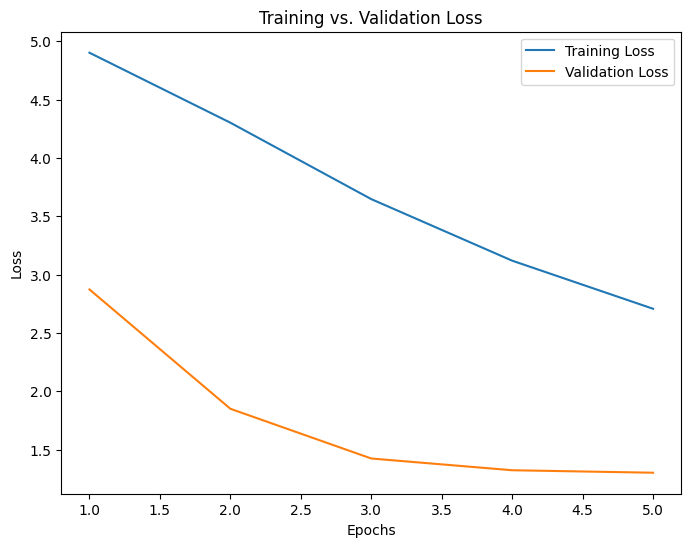

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

# Extract training and validation loss from logs
train_loss = [log['loss'] for log in logs if 'loss' in log]
val_loss = [log['eval_loss'] for log in logs if 'eval_loss' in log]
# Extract the number of epochs for validation loss
epochs = range(1, len(val_loss) + 1)

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss[:len(val_loss)], label='Training Loss')  # Slice training loss to match validation loss length
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()


In [ ]:
# Save the fine-tuned model
model.save_pretrained("./fine_tuned_microllama")
tokenizer.save_pretrained("./fine_tuned_microllama")


('./fine_tuned_microllama/tokenizer_config.json',
 './fine_tuned_microllama/special_tokens_map.json',
 './fine_tuned_microllama/tokenizer.model',
 './fine_tuned_microllama/added_tokens.json',
 './fine_tuned_microllama/tokenizer.json')

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Load the fine-tuned model and tokenizer
model = AutoModelForCausalLM.from_pretrained("./fine_tuned_microllama")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_microllama")

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Sample test data (prompt and expected response)
test_data = [
    {"prompt": "3 + 5", "expected_response": "8"},
    {"prompt": "10 - 2", "expected_response": "8"},
    {"prompt": "(6 * 4) + 2", "expected_response": "26"},
]

# Function to calculate accuracy
def evaluate_model(model, tokenizer, test_data):
    correct_predictions = 0

    for data in test_data:
        prompt = data['prompt']
        expected_response = data['expected_response']

        # Tokenize and generate the model's response
        inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True).to(device)
        output = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=50, pad_token_id=tokenizer.eos_token_id)

        # Decode the model's output and remove special tokens
        generated_response = tokenizer.decode(output[0], skip_special_tokens=True).strip()

        # Compare the generated response with the expected response
        if generated_response == expected_response:
            correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / len(test_data)
    return accuracy

# Evaluate the model's accuracy
accuracy = evaluate_model(model, tokenizer, test_data)
print(f"Model accuracy: {accuracy * 100:.2f}%")


Model accuracy: 0.00%


In [ ]:
print(inputs)

{'input_ids': tensor([[    1, 29871, 29941,   718, 29871, 29945,   334, 29871, 29906]],
       device='cuda:0'), 'attention_mask': tensor([[0, 0, 1, 0, 0, 1, 1, 0, 1]], device='cuda:0')}


Attention mask from ast

In [ ]:
import ast
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

# Function to parse input and generate AST
def generate_ast(input_expression):
    try:
        tree = ast.parse(input_expression, mode='eval')  # 'eval' mode for expressions
        return tree
    except SyntaxError as e:
        print(f"Syntax Error in input: {input_expression}")
        return None

In [ ]:
# Traverse the AST and map tokens to attention mask
class ASTVisitor(ast.NodeVisitor):
    def __init__(self):
        self.tokens_to_focus_on = []  # List to store important tokens

    def visit_BinOp(self, node):
        # Visit binary operation nodes and store operands and operator
        self.tokens_to_focus_on.append(node.left)   # Operand (left side)
        self.tokens_to_focus_on.append(node.op)     # Operator (+, -, *, etc.)
        self.tokens_to_focus_on.append(node.right)  # Operand (right side)
        self.generic_visit(node)

    def visit_Num(self, node):
        self.tokens_to_focus_on.append(node)

    def visit_Constant(self, node):
        self.tokens_to_focus_on.append(node)


In [ ]:
import torch
from transformers import AutoTokenizer

# Function to create an AST-based attention mask and map tokens to AST nodes
def create_ast_attention_mask(tokenized_input, tokens_to_focus_on, tokenizer):
    attention_mask = []
    token_ast_map = []

    # Extract tokens from the tokenized input
    input_ids = tokenized_input['input_ids'][0]  # Assuming we are dealing with a batch of size 1
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # For each token in the tokenized input, check if it corresponds to an important token in the AST
    for token_id in input_ids:
        token_str = tokenizer.decode([token_id]).strip()

        matched_node = None
        attention_value = 0

         # Map constants and numbers
        if any(isinstance(node, (ast.Constant, ast.Num)) and str(node.value) == token_str for node in tokens_to_focus_on):
            matched_node = f"Constant: {token_str}"
            attention_value = 1  # Focus on this token

        # Map all arithmetic operations
        elif any(isinstance(node, ast.BinOp) and isinstance(node.op, ast.Add) and token_str == "+" for node in tokens_to_focus_on):
            matched_node = "Addition Operator"
            attention_value = 1  # Focus on addition
        elif any(isinstance(node, ast.BinOp) and isinstance(node.op, ast.Sub) and token_str == "-" for node in tokens_to_focus_on):
            matched_node = "Subtraction Operator"
            attention_value = 1  # Focus on subtraction
        elif any(isinstance(node, ast.BinOp) and isinstance(node.op, ast.Mult) and token_str == "*" for node in tokens_to_focus_on):
            matched_node = "Multiplication Operator"
            attention_value = 1  # Focus on multiplication
        elif any(isinstance(node, ast.BinOp) and isinstance(node.op, ast.Div) and token_str == "/" for node in tokens_to_focus_on):
            matched_node = "Division Operator"
            attention_value = 1  # Focus on division
        elif any(isinstance(node, ast.BinOp) and isinstance(node.op, ast.Mod) and token_str == "%" for node in tokens_to_focus_on):
            matched_node = "Modulus Operator"
            attention_value = 1  # Focus on modulus
        elif any(isinstance(node, ast.BinOp) and isinstance(node.op, ast.Pow) and token_str == "**" for node in tokens_to_focus_on):
            matched_node = "Exponentiation Operator"
            attention_value = 1  # Focus on exponentiation
        elif any(isinstance(node, ast.BinOp) and isinstance(node.op, ast.FloorDiv) and token_str == "//" for node in tokens_to_focus_on):
            matched_node = "Floor Division Operator"
            attention_value = 1  # Focus on floor division

        # Add the result to the token-to-AST map and the attention mask
        token_ast_map.append((token_str, matched_node))
        attention_mask.append(attention_value)

    return attention_mask, token_ast_map


# Tokenize input and map tokens to AST nodes
def tokenize_and_create_ast_attention_mask(prompt, tokenizer):

    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    model.resize_token_embeddings(len(tokenizer))

    # Tokenize the input prompt
    tokenized_inputs = tokenizer(prompt, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Generate AST from the input expression
    tree = generate_ast(prompt)

    if tree is None:
        return None, None  # Skip invalid expressions

    # Visit AST and collect important tokens
    visitor = ASTVisitor()
    visitor.visit(tree)

    # Create attention mask and map tokens to AST
    attention_mask, token_ast_map = create_ast_attention_mask(tokenized_inputs, visitor.tokens_to_focus_on, tokenizer)

    # Convert the attention mask into a tensor and reshape it correctly
    attention_mask_tensor = torch.tensor(attention_mask).unsqueeze(0)  # Ensure correct shape: [1, seq_length]

    # Add the attention mask to tokenized inputs
    tokenized_inputs['attention_mask'] = attention_mask_tensor

    return tokenized_inputs, token_ast_map

In [ ]:
# Visualize token-to-AST mapping and attention mask
def visualize_token_ast_mapping(token_ast_map, attention_mask):
    print(f"{'Token':<10} | {'AST Node':<30} | {'Attention Mask':<15}")
    print("-" * 60)
    for idx, (token, ast_node) in enumerate(token_ast_map):
        ast_node_str = ast_node if ast_node else "None"
        print(f"{token:<10} | {ast_node_str:<30} | {attention_mask[idx]:<15}")

In [ ]:
# Load the fine-tuned model and tokenizer
model = AutoModelForCausalLM.from_pretrained("./fine_tuned_microllama")
tokenizer = AutoTokenizer.from_pretrained("./fine_tuned_microllama")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example prompt
prompt = "3 * 5 + 2 "

# Tokenize input and generate AST-based attention mask
inputs, token_ast_map = tokenize_and_create_ast_attention_mask(prompt, tokenizer)

# Move inputs to the device (GPU/CPU)
inputs = {key: value.to(device) for key, value in inputs.items()}

# Print token-to-AST mapping and the corresponding attention mask
visualize_token_ast_mapping(token_ast_map, inputs['attention_mask'][0].tolist())

"""# Generate the response
output = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=50)

# Decode the generated response
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("\nGenerated Text:")
print(generated_text)
"""

# Use top-k and top-p sampling to avoid repetitive output (adjustment in the sampling code)
output = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=50,
    do_sample=True,         # Enable sampling to avoid greedy decoding
    top_k=30,               # Lower top-k for less randomness
    top_p=0.85,             # Lower top-p (nucleus) for more deterministic sampling
    temperature=0.6,        # Lower temperature for more controlled output
    pad_token_id=tokenizer.eos_token_id  # Ensure padding is handled correctly
)

# Decode the output and clean it up
generated_text = tokenizer.decode(output[0], skip_special_tokens=True).strip()


print(f"Question: {prompt}")
print(f"Answer: {generated_text}")

Token      | AST Node                       | Attention Mask 
------------------------------------------------------------
<s>        | None                           | 0              
           | None                           | 0              
3          | Constant: 3                    | 1              
*          | Multiplication Operator        | 1              
           | None                           | 0              
5          | Constant: 5                    | 1              
+          | None                           | 0              
           | None                           | 0              
2          | Constant: 2                    | 1              
           | None                           | 0              
Question: 3 * 5 + 2 
Answer: = 3 * 5 + 2 1 *522 *523 *524 *525 *526 *527 *528 *529 *530 *53
